<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier

from catboost import FeaturesData, Pool, CatBoostClassifier
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

### young kagglershers
**Savva Yana, BSE-163 ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ** <br/>
**Starovoyt Anna, BSE-161  ฅ^•ﻌ•^ฅ** <br/>
**Mariampillay Margarita, BSE-163   ლ( ̅°̅ ੪ ̅°̅ )ლ** <br/>

# Task

In this task we are working with posts on famous russian advertisement and resell platform. <br/>
Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days. <br/>
Below you will find some desirable stages of your report.

# Data Loading

In [9]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test_nolabel.tsv', sep='\t')
full_data = pd.concat((train, test), ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
del train['Unnamed: 0']
del test['Unnamed: 0']

# Preprocessing

First of all, need to apply so called *method pristal'nogo vzgl'ada* to our data.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311484 entries, 0 to 311483
Data columns (total 19 columns):
category_id           311484 non-null int64
city                  311484 non-null object
date_created          311484 non-null object
delivery_available    311484 non-null bool
desc_text             311484 non-null object
img_num               311484 non-null int64
lat                   311484 non-null float64
long                  311484 non-null float64
name_text             311484 non-null object
owner_id              311484 non-null object
payment_available     311484 non-null bool
price                 311484 non-null float64
product_id            311484 non-null object
product_type          311484 non-null int64
properties            311484 non-null object
region                311484 non-null object
sold_mode             311483 non-null float64
subcategory_id        311483 non-null float64
sold_fast             311483 non-null float64
dtypes: bool(2), float64(6), int64(

In [13]:
train.groupby(['sold_mode', 'sold_fast'])['delivery_available', 'payment_available'].mean()

delivery_available  payment_available
sold_mode sold_fast                                       
1.0       0.0                  0.325071           0.589923
          1.0                  0.329815           0.596272
2.0       0.0                  0.539069           1.000000
          1.0                  0.544974           0.998942

Hypothesis regarding feature `sold_mode` - oneline/offline purchase in future (assuming that this product will be still on the marketplace), where 1 - was bought offline or wasn't bought at all, 2 - was bought online. (see the results above)

In [0]:
train.delivery_available = train.delivery_available.apply(int)
test.delivery_available = test.delivery_available.apply(int)


train.payment_available = train.payment_available.apply(int)
test.payment_available = test.payment_available.apply(int)


train.price = train.price.apply(int)
test.price = test.price.apply(int)

## Some brand new features

In [0]:
# the more normal distribution the better
train['price_log'] = np.log(train.price + 0.01)
test['price_log'] = np.log(test.price + 0.01)

In [0]:
deal_counts = full_data.groupby('owner_id').count().product_id
def cnt_converter(x):
    if deal_counts[x] > 20:
        return 5
    if deal_counts[x] > 10:
        return 4
    if deal_counts[x] > 3:
        return 3
    return deal_counts[x]

train['owner_experience'] = train.owner_id.apply(cnt_converter)
test['owner_experience'] = test.owner_id.apply(cnt_converter)

In [0]:
train['desc_words_number'] = train.desc_text.apply(lambda x: len(x.split()))
train['name_words_number'] = train.name_text.apply(lambda x: len(x.split()))

test['desc_words_number'] = test.desc_text.apply(lambda x: len(x.split()))
test['name_words_number'] = test.name_text.apply(lambda x: len(x.split()))

## Clap rare categorical features

Using cities table to clap regions, which is a third-party data but still

In [0]:
cities = pd.read_excel('data/spisok_gorodov_v_rossii-1021j.xlsx').drop(['SNo', 'Население', 'Основание или первое упоминание'], axis=1)

cities.index=cities['Город']
del cities['Город']
cities.columns = ['region', 'okrug']

cities = cities.drop_duplicates().to_dict('index')

In [0]:
train.region = train.region.apply(lambda x: (cities[x]['region'] if x in cities else x))
test.region = test.region.apply(lambda x: (cities[x]['region'] if x in cities else x))

In [0]:
# this manipulations will help clap rare feature values and make the column itself cleaner
rare_cities = full_data.city.value_counts().keys()[np.where(full_data.city.value_counts() < 100)]

train.loc[train.city.isin(rare_cities), 'city'] = train[train.city.isin(rare_cities)].\
                                                                region.apply(lambda x: "Город из " + x)
test.loc[test.city.isin(rare_cities), 'city'] = test[test.city.isin(rare_cities)].\
                                                                region.apply(lambda x: "Город из " + x)

In [0]:
# same actions with category and subcategory - getting rid of heavy tail of rare values
rare_subcategories = full_data.subcategory_id.value_counts().keys()[np.where(full_data.subcategory_id.value_counts() < 100)]

train.loc[train.subcategory_id.isin(rare_subcategories), 'subcategory_id'] = -1 * train[train.subcategory_id.isin(rare_subcategories)].\
                                                                category_id
test.loc[test.subcategory_id.isin(rare_subcategories), 'subcategory_id'] = -1 * test[test.subcategory_id.isin(rare_subcategories)].\
                                                                category_id



## Date converting

Converting dates as interval to closest holiday, events, as deltas and some categorical interpretation - weekdat, month and stuff.

In [0]:
train.date_created = pd.to_datetime(train.date_created)
test.date_created = pd.to_datetime(test.date_created)


train['days_before_school_start'] = train.date_created.\
            apply(lambda x: (datetime(x.year, 9, 1) - x).days if x < datetime(x.year, 9, 1)
                  else (datetime(x.year + 1, 9, 1) - x).days)

train['days_before_newyear'] = train.date_created.\
            apply(lambda x: (datetime(x.year, 12, 31) - x).days)

train['days_after_last_newyear'] = train.date_created.\
            apply(lambda x: (x - datetime(x.year - 1, 12, 31)).days)

train['weekday_created'] = train.date_created.dt.weekday

train['monthweek_created'] = train.date_created.dt.week


test['days_before_school_start'] = test.date_created.\
            apply(lambda x: (datetime(x.year, 9, 1) - x).days if x < datetime(x.year, 9, 1)
                  else (datetime(x.year + 1, 9, 1) - x).days)

test['days_before_newyear'] = test.date_created.\
            apply(lambda x: (datetime(x.year, 12, 31) - x).days)

test['days_after_last_newyear'] = test.date_created.\
            apply(lambda x: (x - datetime(x.year - 1, 12, 31)).days)

test['weekday_created'] = test.date_created.dt.weekday

test['monthweek_created'] = test.date_created.dt.week

## Converting lat and long as coordinates x, y, z 
(see https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature)

In [0]:
train['x_coordinate'] = np.cos(train.lat) + np.cos(train.long)
train['y_coordinate'] = np.sin(train.lat) + np.sin(train.long)
train['z_coordinate'] = np.sin(train.lat)

del train['lat']
del train['long']


test['x_coordinate'] = np.cos(test.lat) + np.cos(test.long)
test['y_coordinate'] = np.sin(test.lat) + np.sin(test.long)
test['z_coordinate'] = np.sin(test.lat)

del test['lat']
del test['long']

## OneHot for product_type

In [0]:
train.product_type = train.product_type.apply(lambda x : int(x == 1))
test.product_type = test.product_type.apply(lambda x : int(x == 1))

## Text features processing

The idea is as follows:
* getting rid of unneeded stuff like ☺️❤️💅
* tokenizing
* lemmatizing
* building fastText vectors on description + name docs (of size 5)
* getting final doc vector as weighted with tf idf sum of tokens' vectors

In [0]:
import pymorphy2
import re
morph = pymorphy2.MorphAnalyzer()

In [28]:
%%time

def tokenize(s):
    """
    Leaving alphanumeric with spaces yo be split. Straight-forward way withput keeping the track of punctuation.
    """
    return re.sub(r'([^\s\w]|_)+', '', s).split()

def lemmatize(tokens):
    """
    Here I want to leave CAPS words, coz they actually differ significantly
    """
    return [morph.normal_forms(token)[0] if not token.isupper() else morph.normal_forms(token)[0].upper() for token in tokens]

def convert_text(s):
    return lemmatize(tokenize(s))

train['name_lemm'] = train.name_text.apply(convert_text)
train['desc_lemm'] = train.desc_text.apply(convert_text)

test['name_lemm'] = test.name_text.apply(convert_text)
test['desc_lemm'] = test.desc_text.apply(convert_text)

CPU times: user 39min 17s, sys: 8.58 s, total: 39min 25s
Wall time: 39min 27s


In [0]:
train['name_lemm_string'] = train['name_lemm'].apply(lambda x: " ".join(x))
train['desc_lemm_string'] = train['desc_lemm'].apply(lambda x: " ".join(x))

test['name_lemm_string'] = test['name_lemm'].apply(lambda x: " ".join(x))
test['desc_lemm_string'] = test['desc_lemm'].apply(lambda x: " ".join(x))

In [0]:
# intermediate state to backup
train.to_csv('train_inter.csv')
test.to_csv('test_inter.csv')

In [0]:
# will be using for weighted w2v or whatever
tfidf_desc = TfidfVectorizer(ngram_range=(1,1))
_ = tfidf_desc.fit(train['desc_lemm_string'].values.tolist() + test['desc_lemm_string'].values.tolist())
desc_word2tfidf = dict(zip(tfidf_desc.get_feature_names(), tfidf_desc.idf_))

tfidf_name = TfidfVectorizer(ngram_range=(1,1))
_ = tfidf_name.fit(train['name_lemm_string'].values.tolist() + test['name_lemm_string'].values.tolist())
name_word2tfidf = dict(zip(tfidf_name.get_feature_names(), tfidf_name.idf_))

In [0]:
train['text_lemm'] = train['name_lemm'] + train['desc_lemm']
test['text_lemm'] = test['name_lemm'] +  test['desc_lemm']

In [38]:
%%time
from gensim.models import FastText

fasttext = FastText(sentences=train['text_lemm'].values.tolist() + test['text_lemm'].values.tolist(),
                    size=5, window=3, min_count=1, sg=1)

CPU times: user 8min 46s, sys: 1.14 s, total: 8min 47s
Wall time: 5min 3s


In [40]:
%%time
train_name_vec = train.name_lemm.apply(lambda x: pd.Series(sum([fasttext.wv[word] * name_word2tfidf[word] 
                                                   if word in name_word2tfidf else 0
                                                   for word in x]), 
                                          index=["name_vec" + str(i) for i in range(5)]))
train_desc_vec = train.desc_lemm.apply(lambda x: pd.Series(sum([fasttext.wv[word] * desc_word2tfidf[word] 
                                                   if word in desc_word2tfidf else 0
                                                   for word in x]), 
                                          index=["desc_vec" + str(i) for i in range(5)]))


test_name_vec = test.name_lemm.apply(lambda x: pd.Series(sum([fasttext.wv[word] * name_word2tfidf[word] 
                                                   if word in name_word2tfidf else 0
                                                   for word in x]), 
                                          index=["name_vec" + str(i) for i in range(5)]))
test_desc_vec = test.desc_lemm.apply(lambda x: pd.Series(sum([fasttext.wv[word] * desc_word2tfidf[word] 
                                                   if word in desc_word2tfidf else 0
                                                   for word in x]), 
                                          index=["desc_vec" + str(i) for i in range(5)]))

CPU times: user 8min 43s, sys: 9.58 s, total: 8min 53s
Wall time: 8min 52s


In [0]:
train = pd.concat((train, train_desc_vec, train_name_vec), axis=1)
test = pd.concat((test, test_desc_vec, test_name_vec), axis=1)

Previousely, were using simple TF IDF vectors for desc and name, which didn't show well

In [0]:
# %%time
# ### TFIDF Vectorizer ###
# tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
# full_tfidf = tfidf_vec.fit_transform(train['name_text'].values.tolist() + test['name_text'].values.tolist())
# train_tfidf = tfidf_vec.transform(train['name_text'].values.tolist())
# test_tfidf = tfidf_vec.transform(test['name_text'].values.tolist())

# ### SVD Components ###
# n_comp = 3
# svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
# svd_obj.fit(full_tfidf)
# train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
# test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
# train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
# test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
# train = pd.concat([train, train_svd], axis=1)
# test = pd.concat([test, test_svd], axis=1)
# del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

CPU times: user 3.09 s, sys: 488 ms, total: 3.58 s
Wall time: 3 s


In [0]:
# %%time
# ### TFIDF Vectorizer ###
# tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
# full_tfidf = tfidf_vec.fit_transform(train['desc_text'].values.tolist() + test['desc_text'].values.tolist())
# train_tfidf = tfidf_vec.transform(train['desc_text'].values.tolist())
# test_tfidf = tfidf_vec.transform(test['desc_text'].values.tolist())

# ### SVD Components ###
# n_comp = 3
# svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
# svd_obj.fit(full_tfidf)
# train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
# test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
# train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
# test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
# train = pd.concat([train, train_svd], axis=1)
# test = pd.concat([test, test_svd], axis=1)
# del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

CPU times: user 10.9 s, sys: 1.31 s, total: 12.2 s
Wall time: 10.6 s


# EDA

In [1]:
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [5]:
temp_series = train.region.value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

<img src="https://lh3.googleusercontent.com/y7icLTOE9WTqFSYbrDwF1T5hHtTPSku2SfNf5zk-1_ra3cnlX17LGq3SSbcO2Ir9x-Ii9Q8KACA23t_pO8aeN05_FyQWWUzZ0aThYcBzb0zxgqUwQzPtHOoy9vB0wsv6BTYK4qEP1sQtI9WEmyV-Uv_j_tp-Dt2RxbgKlrP6NsQ8V7sSkYBsS0N6PQhbABnLlNpZGNNSopoqGiX2KVa7cW4ommTWDCe6Ma-6DTcsTN1PfiaqTHEG_TflRwuefB022un1izG0lNFRTO1l1YVSMMm9_WjDwwzraFspxlR4emswzglEPNbwNqwbghvzTTzp_G9Zjq_f5mDni8ehXPpy5jYx6TJ2xKKw0rTwiFMwmg6lS2hvCGkDqB9ABLKROxLlXLYfWlo5EupVD14mnuvRYHWO83rpyDpPrhWuW_wgsF1iCJzKsubsBw3ynVZVHvze8cqLwUuWNmAe93Cg-kmsK_WqwA4iqZutWuxpgaVQe3v7cxFT_lAhWU4WbbCpAWVCrUyb0b_SCn5FGyutlzO78uia_mQAZEeA6B4H7peo2S3-PECdCtewG6Q6cGMgX3RDgkl3Xzc4DxT9cyryx0A2UWfRa6k3mPzcZ57pHHjhlARQTjmfqr01gRFQEX-MjMsZXPm1MIu1SWR0Y3ZbsR5aTJsLiGZdE3YDDULjNObGnUZYC4dJFUsC2BB0K-t9vLB1fzOJwYKqzeab37FB2F70zolz=w1298-h1228-no">

Obviousely, Moscow and St. Petersburg are the most frequent points of products, however the rest distribution is quite informative as well.

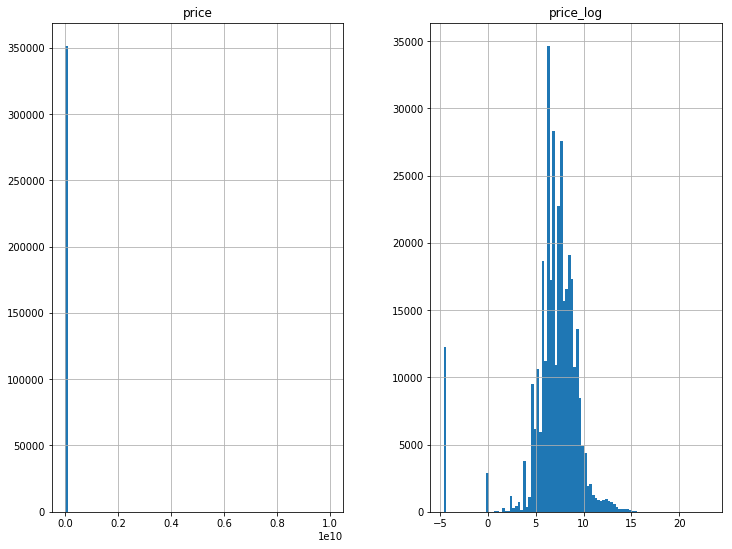

In [6]:
_ = train[['price', 'price_log']].hist(bins=100, figsize=(12,9))

As can be easily noticed - price distrib was very noisy, with heavy tail, which can and should be solved by taking log of the feature.

In [7]:
cnt_srs = train.name_text.apply(lambda x: len(x.split())).value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords") 

<img src="https://lh3.googleusercontent.com/F18At9wzjH3TDal6tMXE96wdT7mYcBevQbBieWQITR11H4sEY4cpfFqDLqP8Ak8_50V88FA5KLRJOnc8PRGx20u1UnfgMQXaIWW3cfSfd-me3A4H3-gIRHeJHiN6MpjO4R0xvTMzjHoeD6avadIMB9JeRKdLnwA2FBj4r_-ulFSQv5SXQ1AJ1zqGg36ScsKkTvOdDQis6GamSh2eYny86FvgtQIQsEFwIMuZ6JuRci9H_sjL5rTZECx_n_MflUQ5kgwF-aQfpZJ8HV9IBdYvpmOzr9Njhg1wonqYU28gwUX9jaR4obPlv-LF-PyQsBqTu5vp84xjk4_xJMqvelVWomy3CJ5iyH_VKYsBXu7NrVlmErtFQP_qvONYLyBb39psTEdHreGrbNyLrqof8vDMfT2Hjkf6EA58JmcF5R89Bl1RYMwkEz1Z8Tt6E4eocKDRbHtU5evoMDFpR3ZqBulun_uXEc_DRUvynmPS4ulYR1Ly-CdgjBMxGPz71AwPfzC08w4cKzSuxnuTwIZVG7c69Jw_hErC6uwfNRk5V8LIwSbu0AM3TZt7OPq8waHs2arcql2Hp9RSqM5Hv6MTksxoSwJgLuVWAP6hOiwm0Mg5Zt1zrw7G8mxdUOXQBV60PyvUdXyK63ynnizv8TnpufJn-LwUOnq4qE2ABtR7tPa8TJy-m5yErWuvGBtThy0RIXztU2BlLbuU3ipL1AqlUndrinRR=w2002-h990-no">

In [8]:
cnt_srs = train.desc_text.apply(lambda x: len(x.split())).value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in desription column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords") 

<img src="https://lh3.googleusercontent.com/7lgGUlIwFEhhZqg4UdtbQD6YGWHgkAPbyLEBraJU20qfKrUC4vvPZmc5RQtotWAyvD1y7cikQxBDcUJqjFRWcb18E1PPSQuzuN8hRf7_NjlWKvy4iUav8zuCGs4vrhEU3XtU78gLfCG1tE7NYIaQz9B7SZznLY-pBkFVVIFPDG8cHL1966e0J6jpSCDf-KhTkjHZkJMgM_hSqjyO7L_lSdgo2FO4AWNNB1DGJ2560_wvGmtXR7EmoTcPBFq0WcaI9F15G4BUnV_yZzPzEwOSe9wemkGhPrLT4ognTKrdKj6F3C5l8J1AVqU8-ARgWbYR-L6X_uxuN9IqPUrJhbboMovFkMxhK0jJjF35cIIpLapaUJWki5GrLWQPD4wM_kFtPkbs1xk4RXVjZOdcSzkVxA6LsPK0P3jaXe5xcynZkKL2tqRy72quF5Y0zZEn2nTr--TvdKyLyvuDMwoRZDQSMGlVsqpruTjH65AiPOxXqhfmK39bJUztSrH3v0b8AJvnA-ESEdHC6f7AN7pFmJbKIQSal5_9Wb2KmIcmYEUvEOXjkoPG9y_8T975nxyPRsc9hOVF8dkTbefiYTI5Ko1BovoK-btjtxY0JLG2guUNkFx7somTPiYTHc0ZqU9exJoa3n0psprswT7BWl5rQyGut5zoi5eHYETqrZbJJHYoVxaH1h1aG-zEV-t13JzipIhR8JGel0TDP1xVU0y0CXY7Z_7U=w1948-h976-no">

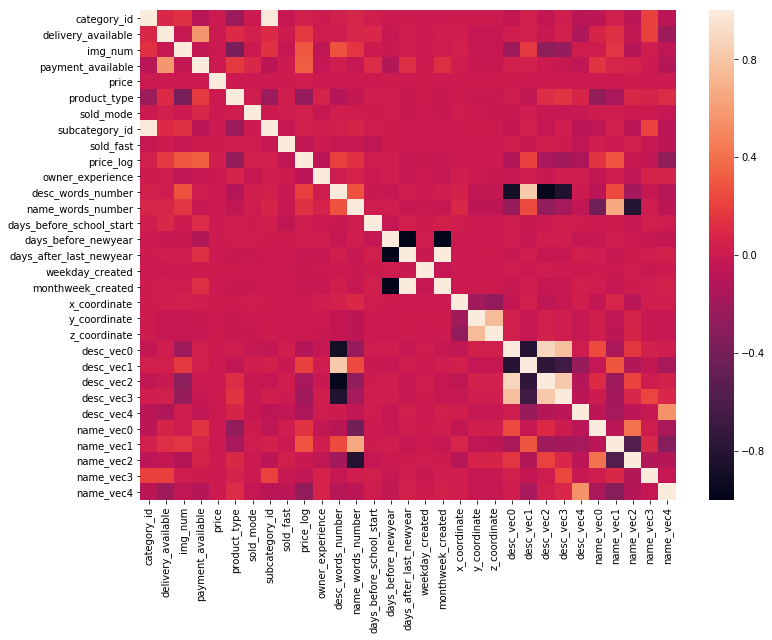

In [11]:
plt.figure(figsize=(12,9))
_ = sns.heatmap(train.corr())

Let's deeg in what is shown above - we can see some strongly negatively correlated features - time features and name/desc. First one (like `days_before_newyear`) can be interpreted as the closer to newyear (feature decreases) the more people by things quickly. Whereas with name and description features the situation is more complicated because vector representations of text are not humanly recognizable.

# Test Train

The idea ia simple - winter is high season for some gloves-hats-coats-kinda products, so we want our model to pay attention to them and give them higher weights, which are used duting loss evaluation while training.

In [0]:
# that was manually gathered by again method pristal'nogo vzgl'ada
winter_subcategory_ids = [2204, 2217, 2206, 2202]

In [0]:
# finding winter-meaningful samples
winter_idxs = train.name_lemm.apply(lambda x: 'зима' in x or 'зимний' in x) & train.desc_lemm.apply(lambda x: 'зима' in x or 'зимний' in x)

In [0]:
# adding samples with winter subcategory
winter_idxs = set(list(train[winter_idxs].index) + list(train[train.subcategory_id.isin(winter_subcategory_ids)].index))

In [0]:
# leaving indexes needed for train
winter_idxs = winter_idxs.intersection(set(X_train.index))

In [27]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [13]:
# reading previousely downloaded data

train = pd.read_csv('data/train_proc.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data/test_proc.csv').drop('Unnamed: 0', axis=1)

In [14]:
train.dropna(inplace=True)

In [15]:
X, y = train.drop(['date_created', 'desc_text', 'name_text', 'properties',
                  'sold_fast', 'owner_id', 'product_id', 'name_lemm',
                   'desc_lemm', 'name_lemm_string',  'text_lemm'], axis=1), train.sold_fast

In [16]:
# data for submission
X_test = test.drop(['date_created', 'desc_text', 'name_text', 'properties',
                   'owner_id', 'product_id', 'name_lemm',
                   'desc_lemm', 'name_lemm_string',  'text_lemm'], axis=1)

product_id = test.product_id

In [17]:
cat_features = ['category_id', 'city', 'product_type', 'region',
               'subcategory_id']
numerical_features = list(set(X.columns) - set(cat_features))

In [18]:
X[cat_features] = X[cat_features].astype(str)
X[numerical_features] = X[numerical_features].astype(np.float32)

X_test[cat_features] = X_test[cat_features].astype(str)
X_test[numerical_features] = X_test[numerical_features].astype(np.float32)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
# trying this to add weights for winter products
winter_subcategory_ids = list(map(str, winter_subcategory_ids))
weights = pd.Series(X_train.index).apply(lambda x: 0.5 if x in winter_idxs else 0.2)

In [185]:
len(weights[weights==0.5])

8434

Another idea - trying to struggle with imbalanced target class by undersampling (thanks god we've got huge amount of data!)

In [0]:
# trying this to under sample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
X_resampled[cat_features] = X_resampled[cat_features].astype(str)
X_resampled[numerical_features] = X_resampled[numerical_features].astype(np.float32)

# Modeling

Catboost and lightGBM were tried, which is quite unnecessary due to their similarity, but you know - WHY NOT?

## Catboost

In [20]:
from catboost import FeaturesData, Pool, CatBoostClassifier

In [21]:
features_train = FeaturesData(X_train[numerical_features].values, X_train[cat_features].values,
                        num_feature_names=numerical_features, cat_feature_names=cat_features)
pool = Pool(features_train, label=y_train, weight=weights)

# features_train = FeaturesData(X_resampled[numerical_features].values, X_resampled[cat_features].values,
#                         num_feature_names=numerical_features, cat_feature_names=cat_features)
# pool = Pool(features_train, label=y_resampled)

In [22]:
features_val = FeaturesData(X_val[numerical_features].values, X_val[cat_features].values,
                        num_feature_names=numerical_features, cat_feature_names=cat_features)
features_test = FeaturesData(X_test[numerical_features].values, X_test[cat_features].values,
                        num_feature_names=numerical_features, cat_feature_names=cat_features)

In [24]:
pool_val = Pool(features_val, y_val)

In [187]:
%%time
model = CatBoostClassifier(iterations=2000, random_seed=42, eval_metric='AUC')\
                                            .fit(pool, use_best_model=True, eval_set=pool_val)

Learning rate set to 0.102906
0:	test: 0.6015734	best: 0.6015734 (0)	total: 489ms	remaining: 16m 17s
1:	test: 0.6070736	best: 0.6070736 (1)	total: 931ms	remaining: 15m 30s
2:	test: 0.6094339	best: 0.6094339 (2)	total: 1.55s	remaining: 17m 14s
3:	test: 0.6094323	best: 0.6094339 (2)	total: 2.15s	remaining: 17m 55s
4:	test: 0.6102418	best: 0.6102418 (4)	total: 2.73s	remaining: 18m 9s
5:	test: 0.6101054	best: 0.6102418 (4)	total: 3.31s	remaining: 18m 20s
6:	test: 0.6153049	best: 0.6153049 (6)	total: 3.91s	remaining: 18m 32s
7:	test: 0.6166056	best: 0.6166056 (7)	total: 4.47s	remaining: 18m 33s
8:	test: 0.6176192	best: 0.6176192 (8)	total: 5.04s	remaining: 18m 33s
9:	test: 0.6181892	best: 0.6181892 (9)	total: 5.68s	remaining: 18m 49s
10:	test: 0.6196899	best: 0.6196899 (10)	total: 6.22s	remaining: 18m 45s
11:	test: 0.6204898	best: 0.6204898 (11)	total: 6.83s	remaining: 18m 51s
12:	test: 0.6215740	best: 0.6215740 (12)	total: 7.37s	remaining: 18m 47s
13:	test: 0.6218877	best: 0.6218877 (13)	t

In [0]:
model.save_model('model.cbm')

In [0]:
# files.download('model.cbm')

## LightGBM

In [0]:
import lightgbm as lgbm

In [97]:
# since lightGBM unlike catboost (<3) needs encoded representation of categorical features - need to LabelEncode them first
from sklearn.preprocessing import LabelEncoder

X_train_encoded, X_val_encoded, X_test_encoded = X_train.copy(), X_val.copy(), X_test.copy()
for cat in cat_features:
    encoder = LabelEncoder().fit(pd.concat((X, X_test), axis=0)[cat])
    X_train_encoded[cat] = encoder.transform(X_train_encoded[cat])
    X_test_encoded[cat] = encoder.transform(X_test_encoded[cat])
    X_val_encoded[cat] = encoder.transform(X_val_encoded[cat])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [0]:
dataset_train = lgbm.Dataset(X_train_encoded, y_train, weight=weights)
dataset_val = lgbm.Dataset(X_val_encoded, y_val)
dataset_test = lgbm.Dataset(X_test_encoded)

In [101]:
%%time
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc'
}
lgbm_model = lgbm.train(params=parameters, train_set=dataset_train, valid_sets=dataset_val, num_boost_round=500)

[1]	valid_0's auc: 0.608025
[2]	valid_0's auc: 0.612655
[3]	valid_0's auc: 0.614498
[4]	valid_0's auc: 0.616774
[5]	valid_0's auc: 0.617403
[6]	valid_0's auc: 0.619451
[7]	valid_0's auc: 0.620382
[8]	valid_0's auc: 0.620744
[9]	valid_0's auc: 0.621908
[10]	valid_0's auc: 0.622605
[11]	valid_0's auc: 0.623474
[12]	valid_0's auc: 0.623696
[13]	valid_0's auc: 0.624305
[14]	valid_0's auc: 0.624589
[15]	valid_0's auc: 0.625194
[16]	valid_0's auc: 0.625585
[17]	valid_0's auc: 0.626267
[18]	valid_0's auc: 0.626712
[19]	valid_0's auc: 0.626932
[20]	valid_0's auc: 0.627139
[21]	valid_0's auc: 0.627737
[22]	valid_0's auc: 0.628024
[23]	valid_0's auc: 0.628347
[24]	valid_0's auc: 0.628548
[25]	valid_0's auc: 0.628976
[26]	valid_0's auc: 0.629316
[27]	valid_0's auc: 0.629423
[28]	valid_0's auc: 0.630018
[29]	valid_0's auc: 0.630217
[30]	valid_0's auc: 0.630565
[31]	valid_0's auc: 0.631041
[32]	valid_0's auc: 0.631209
[33]	valid_0's auc: 0.631473
[34]	valid_0's auc: 0.631661
[35]	valid_0's auc: 0.6

## Evaluation

In [0]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

### lightGBM

In [103]:
lgbm_model.best_score #1k iterations, lightgbm

defaultdict(dict, {'valid_0': {'auc': 0.6343563866480042}})

### Catboost

In [18]:
roc_auc_score(y_val, model.predict_proba(features_val)[:,1]) #1k iterations

0.6403640034752354

In [25]:
roc_auc_score(y_val, model.predict_proba(features_val)[:,1]) #1k iterations, weighted positive class

0.6399343823847677

In [39]:
roc_auc_score(y_val, model.predict_proba(features_val)[:,1]) #1k iterations, undersampled

0.6374860694101877

In [87]:
roc_auc_score(y_val, model.predict_proba(features_val)[:,1]) #2k iterations

0.6413965920939263

In [188]:
roc_auc_score(y_val, model.predict_proba(features_val)[:,1]) #2k iterations, trully winter weighted objects

0.6393523844645788

In [83]:
roc_auc_score(y_val, model.predict_proba(features_val)[:,1]) #2k iterations, weighted winter objects

0.6401785110859363

So, what was finally figured out:
* lightGBM with our features and paraneters is unneeded, however it is much faster
* catboost better to use with `use_best_model` parameter
* weghts can give profit, however this is not clear from same train data

## Model interpretation

In [12]:
from catboost import CatBoostClassifier
model = CatBoostClassifier().load_model('model.cbm')

In [27]:
feature_importances = model.get_feature_importance(data=pool_val, verbose=True, prettified=True)

In [29]:
feature_importances_df = pd.DataFrame()
feature_importances_df['Feature'] = [pair[0] for pair in feature_importances]
feature_importances_df['Score'] = [pair[1] for pair in feature_importances]

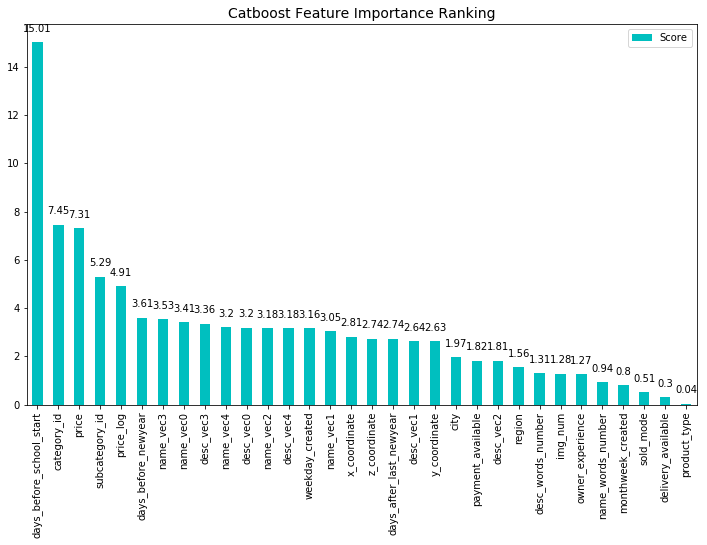

In [31]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_importances_df.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_importances_df['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

Here we can see that model managed to catch some humanly-realizable features like `pice`, season features (`days_before_school/newyear`), category of the product (`category_id`, `subcategory_id`) and, of course, product's name and description represented as `name_vec` and `desc_vec`. This is quite an intuitive result.

## Save these results

In [0]:
predict = model.predict_proba(features_test)[:,1]

In [0]:
submission = pd.DataFrame()

In [0]:
submission['product_id'] = product_id
submission['score'] = predict

In [192]:
submission.shape, test.shape

((89251, 2), (89251, 43))

In [0]:
submission.to_csv('yana_submission.csv', index=False, index_label=False, columns=['product_id', 'score'])

# Improvements

We realized that it's better to use stacked models all together, so that already learned catboost with weghts will be a part of complex ensemle. For other models in this ensemble new features were analized and generated.

## More features

In [ ]:
raw_data = pd.read_csv(train_path, sep = '\t').drop(['Unnamed: 0'], axis=1)

In [0]:
def data_preproc(raw_data, data_preproced):
    data = pd.DataFrame()

    new_features = raw_data.groupby('owner_id').count().product_id
    data['owner_ads'] = data_preproced['owner_id'].apply(lambda x: new_features[x])
    data['month_created'] = data_preproced['date_created'].apply(lambda s: int(s.split('-')[1]))
    data['is_moscow'] = data_preproced['city'].apply(lambda s: int(s.lower() == 'москва')) 
    
    data['great_quality_desc'] = raw_data['desc_text'].apply(lambda s: int('в отличном состоянии' in s.lower() or 
                                                                    'в хорошем состоянии' in s.lower()))
    
    data['cheep_desc'] = data_preproced['text_lemm'].apply(lambda s: int('дешевый' in s.lower() or 
                                                                    'дешево' in s.lower() or
                                                                    'дёшево' in s.lower() or
                                                                    'дёшевый' in s.lower()))

    data['new_desc'] = data_preproced['text_lemm'].apply(lambda s: int('новый' in s.lower()))
    data['free_desc'] = data_preproced['desc_text'].apply(lambda s: int('бесплатно' in s.lower() or 
                                                               'бесплатный' in s.lower() or
                                                               'даром' in s.lower()))
                                                                        
    data['doesnt_fit_desc'] = raw_data['desc_text'].apply(lambda s: int('не подошёл' in s.lower() or 
                                                                 'не подошел' in s.lower() or 
                                                                 'не подошла' in s.lower() or 
                                                                 'не подошло' in s.lower()))
    
    data['bargain_desc'] = raw_data['desc_text'].apply(lambda s: int('торг' in s.lower() or 
                                                              'торг уместен' in s.lower()))
    
    data['asap_desc'] = raw_data['desc_text'].apply(lambda s: int('срочно' in s.lower()))

    data['delivery_desc'] = data_preproced['desc_text'].apply(lambda s: int('доставка' in s.lower()))
    
    data['photo_desc'] = data_preproced['desc_text'].apply(lambda s: int('фотография' in s.lower() or 
                                                                    'фото' in s.lower()))
    
    cool_data_columns = ['category_id', 'delivery_available',
                         'img_num', 'payment_available', 
                         'price', 'product_type', 'region', 'sold_mode',
                         'desc_words_number', 
                         'name_words_number', 'days_before_newyear',
                         'weekday_created',
                         'desc_vec0', 'desc_vec1','desc_vec2', 'desc_vec3', 'desc_vec4', 
                         'name_vec0', 'name_vec1', 'name_vec2', 'name_vec3', 'name_vec4',
                         'properties_amount', 'positive_props', 'negative_props']

    data[cool_data_columns] = data_preproced[cool_data_columns]
    
    return data

In [23]:
data = data_preproc(raw_data, train)
data.head()

,owner_ads,month_created,is_moscow,great_quality_desc,cheep_desc,new_desc,free_desc,doesnt_fit_desc,bargain_desc,asap_desc,delivery_desc,photo_desc,category_id,delivery_available,img_num,payment_available,price,product_type,region,sold_mode,desc_words_number,name_words_number,days_before_newyear,weekday_created,desc_vec0,desc_vec1,desc_vec2,desc_vec3,desc_vec4,name_vec0,name_vec1,name_vec2,name_vec3,name_vec4,properties_amount,positive_props,negative_props
0,1,10,0,0,0,0,0,0,1,0,0,0,4,0,3,1,500,1,Краснодарский край,1,14,1,84,0,-42.933002,78.443886,-205.314636,-35.914284,55.069992,-0.844685,13.941656,-18.348289,-10.181881,10.827452,1.0,0,0
1,1,6,0,0,0,0,0,0,0,0,0,0,4,0,2,0,300,1,Тюменская область,1,27,1,196,0,-169.660995,143.468262,-446.660919,-72.482681,118.517204,-12.114345,8.643595,-22.948046,-14.410407,10.628201,1.0,0,0
2,1,7,0,0,0,1,0,1,0,0,0,0,9,1,1,1,1100,1,Омская область,1,22,1,153,1,-140.334137,74.962807,-354.108215,11.601650,64.478783,-2.593619,8.885111,-23.460974,7.740607,9.950417,2.0,0,0
3,1,4,0,0,0,0,0,0,0,0,0,0,3,0,4,1,5000,1,Ленинградская область,1,77,1,258,1,-392.852814,325.340759,-1436.584717,-473.458832,298.263275,2.459601,10.804501,-16.709982,-5.522973,8.479527,2.0,0,0
4,1,2,1,0,0,0,0,0,0,0,0,0,5,0,2,1,2000,1,Московская область,1,12,2,325,4,-87.576485,21.618368,-213.107635,-22.994753,76.718796,-32.493614,1.114545,-74.757950,6.174096,31.624153,0.0,0,0


In [24]:
val_data = data_preproc(val_data_raw, test)
val_data.head()

,owner_ads,month_created,is_moscow,great_quality_desc,cheep_desc,new_desc,free_desc,doesnt_fit_desc,bargain_desc,asap_desc,delivery_desc,photo_desc,category_id,delivery_available,img_num,payment_available,price,product_type,region,sold_mode,desc_words_number,name_words_number,days_before_newyear,weekday_created,desc_vec0,desc_vec1,desc_vec2,desc_vec3,desc_vec4,name_vec0,name_vec1,name_vec2,name_vec3,name_vec4,properties_amount,positive_props,negative_props
0,2,10,0,0,0,0,0,0,0,0,0,0,9,1,3,1,650,1,Челябинская область,1,14,1,70,0,-62.739876,106.908562,-314.953644,36.535126,124.226906,0.253623,19.629936,-33.682739,11.588150,15.291332,3.0,0,0
1,2,11,0,1,0,0,0,0,0,0,0,0,22,1,2,1,750,1,Алтайский край,1,28,2,52,4,-51.159389,140.807632,-481.056854,-6.949008,150.651398,0.936172,22.775002,-45.430645,13.309261,17.753237,6.0,0,0
2,1,11,0,1,0,0,0,0,0,0,0,0,12,0,4,1,5500,1,Забайкальский край,1,99,9,34,1,-600.964355,805.230774,-1098.966919,-279.786743,-453.027588,-36.664925,152.400406,-128.968140,14.037912,-66.689209,13.0,0,0
3,1,11,1,0,0,0,0,0,0,0,0,0,3,1,2,1,100,1,Московская область,1,11,3,36,6,-41.268032,31.926601,-225.059555,-56.527649,67.010559,-14.356287,18.914415,-70.660217,-26.538942,39.518990,0.0,0,0
4,3,11,0,0,0,1,1,0,0,0,1,0,22,1,2,1,700,1,Новосибирская область,1,10,2,57,6,-74.964615,38.809677,-128.193024,14.841052,19.749659,-2.150110,13.975040,-36.250832,8.840183,11.590187,5.0,0,0


### Some more features (not effective)
Generated from proberties feature
new features:
- properties_amount - we suggested that amount of info could affect target 
- positive_props - characteristics which we consider positive
- negative_props - characteristics which we found negative
- is_used - if the thing was used or not

minuses: 
- not concidering weight of consumer's interest of the property. 
- not concidering difference between goods

Generating for train (for test change "for prop in train...:" to "for prop in test...:"):

In [ ]:
import ast
# parsing data
dicts_list = []
for prop in train["properties"]:
    dicts_list.append(ast.literal_eval(prop))
    
props_series = pd.Series(dicts_list)

# feature 1
props_amount = []
for props in dicts_list:
    props_amount.append(len(props))
    
props_amount = pd.Series(props_amount)

props_amount.describe()

In [ ]:
props_series = pd.Series(dicts_list)
    
yes_series = []
no_series = []
used_series = []

for dicts in props_series:
    count1 = 0
    count2 = 0
    count3 = 0
    
    for i in range(len(dicts)):
        if ((dicts[i]["value"] == "Есть" and (dicts[i]["slug_name"] != "Комиссия")) 
            or ((dicts[i]["value"] == "Да") and (dicts[i]["slug_name"] != "Для детей")) 
            or (dicts[i]["value"] == "Не битый")
            or (dicts[i]["value"] == "Отличное")
            or (dicts[i]["value"] == "Хорошее")):
            count1 += 1
        elif(dicts[i]["slug_id"] == "realty_infrastructure"):
            count1 += 0.5
        elif (((dicts[i]["value"] == "Нет") and (dicts[i]["slug_name"] != "Комиссия")) 
              or (dicts[i]["value"] == "Битый")):
            count2 -= 1
        elif ((dicts[i]["value"] == "Б/у") 
              or (dicts[i]["value"] == "Среднее") 
              or (dicts[i]["value"] == "Битый")):
            count3 -= 1
    # feature 2
    yes_series.append(count1) 
    # feature 3
    no_series.append(count2)
    # feature 4
    used_series.append(count3)

yes_series = pd.Series(yes_series)
no_series = pd.Series(no_series)
used_series = pd.Series(used_series)

df = pd.DataFrame({'properties_amount':props_amount, 'positive_props':yes_series, 'negative_props':no_series, 'is_used':used_series})
df.to_csv("features_from_props.csv")

df.describe()

## Catboost

In [25]:
data.columns

Index(['owner_ads', 'month_created', 'is_moscow', 'great_quality_desc',
       'cheep_desc', 'new_desc', 'free_desc', 'doesnt_fit_desc',
       'bargain_desc', 'asap_desc', 'delivery_desc', 'photo_desc',
       'category_id', 'delivery_available', 'img_num', 'payment_available',
       'price', 'product_type', 'region', 'sold_mode', 'desc_words_number',
       'name_words_number', 'days_before_newyear', 'weekday_created',
       'desc_vec0', 'desc_vec1', 'desc_vec2', 'desc_vec3', 'desc_vec4',
       'name_vec0', 'name_vec1', 'name_vec2', 'name_vec3', 'name_vec4',
       'properties_amount', 'positive_props', 'negative_props'],
      dtype='object')

In [0]:
cat_features = ['month_created', 'is_moscow', 'category_id', 
               'delivery_available', 'payment_available', 'product_type',
               'region', 'sold_mode', 'weekday_created', 
               'great_quality_desc', 'cheep_desc',
               'new_desc', 'free_desc', 'doesnt_fit_desc', 
               'bargain_desc', 'asap_desc', 'delivery_desc', 'photo_desc']

cols = data.columns
numerical_features = list(set(cols) - set(cat_features))

In [0]:
X = data
y = raw_data.sold_fast

X[cat_features] = X[cat_features].astype(str)
X[numerical_features] = X[numerical_features].astype(np.float32)

X_val = val_data
X_val[cat_features] = X_val[cat_features].astype(str)
X_val[numerical_features] = X_val[numerical_features].astype(np.float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


features_test = FeaturesData(X_test[numerical_features].values, 
                             X_test[cat_features].values,
                             num_feature_names=numerical_features, 
                             cat_feature_names=cat_features)

features_val = FeaturesData(X_val[numerical_features].values, 
                            X_val[cat_features].values,
                            num_feature_names=numerical_features, 
                            cat_feature_names=cat_features)

In [0]:
features_train = FeaturesData(X_train[numerical_features].astype(np.float32).values, 
                              X_train[cat_features].values,
                              num_feature_names=numerical_features, 
                              cat_feature_names=cat_features)
pool = Pool(features_train, label=y_train)

In [0]:
%%time
catboost_model = CatBoostClassifier(iterations=1000, random_seed=42, verbose=1).fit(pool)

Learning rate set to 0.078582
0:	learn: 0.6677929	total: 633ms	remaining: 10m 32s
1:	learn: 0.6464132	total: 1.23s	remaining: 10m 13s
2:	learn: 0.6283010	total: 1.76s	remaining: 9m 46s
3:	learn: 0.6124393	total: 2.32s	remaining: 9m 38s
4:	learn: 0.5995896	total: 2.93s	remaining: 9m 43s
5:	learn: 0.5883445	total: 3.33s	remaining: 9m 11s
6:	learn: 0.5790985	total: 3.85s	remaining: 9m 5s
7:	learn: 0.5712717	total: 4.29s	remaining: 8m 51s
8:	learn: 0.5647883	total: 4.74s	remaining: 8m 41s
9:	learn: 0.5592719	total: 5.34s	remaining: 8m 48s
10:	learn: 0.5540151	total: 5.85s	remaining: 8m 46s
11:	learn: 0.5500611	total: 6.37s	remaining: 8m 44s
12:	learn: 0.5468111	total: 6.9s	remaining: 8m 43s


In [0]:
y_pred_catboost = catboost_model.predict_proba(features_test)[:,1]

In [0]:
roc_auc_score(y_test, y_pred_catboost)

In [0]:
y_pred_catboost_val = catboost_model.predict_proba(features_val)[:,1]

## Sklearn preprocessing

In [0]:
le = LabelEncoder()
regions = le.fit_transform(raw_data.region)

In [0]:
regions_set = set(raw_data.region.values)
regions_dict = {}
for i, region in zip(range(len(regions_set)), regions_set):
    regions_dict.update({region: i})

In [0]:
import random

In [0]:
def region_converter(region_str):
    if regions_dict.get(region_str):
        return regions_dict[region_str]
    else:
        return random.randint(0, len(regions_dict)-1)

In [0]:
sklearn_cat_features =  ['is_moscow',
                         'category_id',
                         'delivery_available',
                         'payment_available',
                         'product_type',
                         'sold_mode',
                         'great_quality_desc',
                         'cheep_desc',
                         'new_desc', 
                         'free_desc', 
                         'doesnt_fit_desc', 
                         'bargain_desc', 
                         'asap_desc',
                         'delivery_desc', 
                         'photo_desc']

In [0]:
def sklearn_preproc(X):
    sklearn_preproc_data = X[sklearn_cat_features].astype(np.int32)
    
    for title in sklearn_cat_features:
        tmp_dummies = pd.get_dummies(X[title])
        new_titles = ['{}_one_hot_{}'.format(title, i) for i in range(tmp_dummies.shape[1])]
        tmp_dummies.columns = new_titles
        sklearn_preproc_data[new_titles] = tmp_dummies
        
    sklearn_preproc_data[numerical_features] = X[numerical_features]
    
    return sklearn_preproc_data

In [0]:
X['region'] = raw_data.region.apply(lambda x: region_converter(x))
X_val['region'] = val_data_raw.region.apply(lambda x: region_converter(x))

In [0]:
print(X['region'].shape)
print(X_val['region'].shape)


In [0]:
sklearn_preproc_data = sklearn_preproc(X)
sklearn_preproc_data_val = sklearn_preproc(X_val)

In [0]:
sklearn_preproc_data.head()

In [0]:
sklearn_preproc_data_val.head()

In [0]:
set(sklearn_preproc_data.columns) - set(sklearn_preproc_data_val.columns)

## Sklearn stack ensembles

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sklearn_preproc_data, y, test_size=0.33, random_state=42)


In [0]:
clf1 = RandomForestClassifier(n_estimators=30, max_depth=6)
clf2 = AdaBoostClassifier()
clf3 = GradientBoostingClassifier(n_estimators=50, max_depth=8)

In [0]:
eclf1 = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft')

In [0]:
eclf1.fit(X_train, y_train)

In [0]:
y_pred_sklearn = eclf1.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_sklearn)

In [0]:
y_pred_sklearn_val = eclf1.predict_proba(sklearn_preproc_data_val)[:,1]
y_pred_sklearn_val

Some more methods and techniques were used to get better results, they were archieved for now.

##  Sklearn with scaling

In [0]:
# scaler = StandardScaler()
# scaled_numerical_data = scaler.fit_transform(X[numerical_features])
# X[numerical_features] = scaled_numerical_data

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [0]:
# eclf2 = VotingClassifier(estimators=[('lr', clf1), ('ab', clf2), ('gb', clf3)], voting='soft')
# eclf2.fit(X_train, y_train)

# y_pred = eclf2.predict_proba(X_test)[:,1]
# roc_auc_score(y_test, y_pred)

## Stack more layers

In [0]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Softmax

In [0]:
# model = Sequential()
# model.add(Dense(60, activation='relu', kernel_initializer='random_normal'))
# model.add(Dropout(0.2))
# model.add(Dense(30, activation='relu', kernel_initializer='random_normal'))
# model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
# model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(sklearn_preproc_data, y, test_size=0.33, random_state=42)

In [0]:
# model.fit(X_train.values, y_train.values, batch_size=64, epochs=100)

In [0]:
# y_pred_keras = model.predict(X_test.values)
# roc_auc_score(y_test, y_pred_keras)

In [0]:
# y_mean = np.mean([y_pred_keras.reshape((115923,)), y_pred_catboost, y_pred_sklearn], axis=0)
# y_mult = np.mean([y_pred_keras.reshape((115923,))*y_pred_catboost*y_pred_sklearn], axis=0)

In [0]:
# roc_auc_score(y_test, y_mult)

In [0]:
y_mean_2 = np.mean([y_pred_catboost, y_pred_sklearn], axis=0)
roc_auc_score(y_test, y_mean_2)

## Simple linear model

In [0]:
# sklearn_preproc_data.head()

In [0]:
# X_no_vecs = sklearn_preproc_data.drop(['desc_vec0', 'desc_vec1', 'desc_vec2', 'desc_vec3', 'desc_vec4',
#                                        'name_vec0', 'name_vec1', 'name_vec2', 'name_vec3', 'name_vec4'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X_no_vecs, y, test_size=0.33, random_state=42)

# lin_model_simple = LogisticRegression()
# lin_model_simple.fit(X_train, y_train)
# y_pred_linear_simple = lin_model_simple.predict_proba(X_test)[:,1]
# roc_auc_score(y_test, y_pred_linear_simple)

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(sklearn_preproc_data, y, test_size=0.33, random_state=42)

# lin_model = LogisticRegression()
# lin_model.fit(X_train, y_train)
# y_pred_linear = lin_model.predict_proba(X_test)[:,1]
# roc_auc_score(y_test, y_pred_linear)

## Decision tree simple

In [0]:
# from sklearn.tree import DecisionTreeClassifier

# tree_model = LogisticRegression()
# tree_model.fit(X_train, y_train)
# y_pred_linear = tree_model.predict_proba(X_test)[:,1]
# roc_auc_score(y_test, y_pred_linear)

## Adaboost simple

In [0]:
# adaboost_model = AdaBoostClassifier()
# adaboost_model.fit(X_train, y_train)
# y_pred_ab = adaboost_model.predict_proba(X_test)[:,1]
# roc_auc_score(y_test, y_pred_ab)

## Submission

Final score was calculated as mean of ensemble score (which included catboost as well giving less AUC as standing alone model) and previousely learned weighted catboost.

In [0]:
# ensemble result
y_mean_val = np.mean([y_pred_catboost_val, y_pred_sklearn_val], axis=0)

In [0]:
submission = pd.DataFrame()

product_id = val_data_raw.product_id
submission['product_id'] = product_id
submission['score'] = y_mean_val

In [0]:
# saving ensemble results as it is
submission.to_csv('ann_submission.csv', index=False)

In [0]:
prev_submission = pd.read_csv('yana_submission.csv', sep = ',')

In [0]:
# taking mean of ensemble and weighted catboost results
submission['score'] = np.mean([y_mean_val, np.array(prev_submission['score'])], axis=0)

In [0]:
submission.to_csv('our_submission.csv', index=False)